In [1]:
import pandas as pd

In [2]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [3]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [4]:
#Filtering only English articles
english_articles_df = articles_df[articles_df['lang'] == 'en']
#Concatenating the articles titles and bodies
english_articles_content = (english_articles_df['title'] + ' ' + english_articles_df['text']).tolist()

In [5]:
#Loading a set of English stopwords
english_stopset = set(stopwords.words('english')).union(
                  {"things", "that's", "something", "take", "don't", "may", "want", "you're", 
                   "set", "might", "says", "including", "lot", "much", "said", "know", 
                   "good", "step", "often", "going", "thing", "things", "think",
                  "back", "actually", "better", "look", "find", "right", "example", 
                   "verb", "verbs"})

In [6]:
#Tokenizing words of articles
tokenizer = RegexpTokenizer(r"(?u)[\b\#a-zA-Z][\w&-_]+\b")
english_articles_tokens = list(map(lambda d: [token for token in tokenizer.tokenize(d.lower()) if token not in english_stopset], english_articles_content))

In [7]:
#Processing bigrams from unigrams (sets of two works frequently together in the corpus)
bigram_transformer = models.Phrases(english_articles_tokens)
english_articles_unigrams_bigrams_tokens = list(bigram_transformer[english_articles_tokens])

/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [8]:
#Creating a dictionary and filtering out too rare and too common tokens
english_dictionary = corpora.Dictionary(english_articles_unigrams_bigrams_tokens)
english_dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=None)
english_dictionary.compactify()
print(english_dictionary)

Dictionary(17114 unique tokens: ['columbus', 'covered', 'designing', 'enterprises', 'falling']...)


In [9]:
#Processing Bag-of-Words (BoW) for each article
english_articles_bow = [english_dictionary.doc2bow(doc) for doc in english_articles_unigrams_bigrams_tokens]

In [10]:
#Training the LDA topic model on English articles
lda_model = models.LdaModel(english_articles_bow, id2word=english_dictionary, num_topics=30, passes=10, iterations=500)

In [11]:
#Processing the topics for each article
english_articles_lda = lda_model[english_articles_bow]

In [12]:
def get_topics_top_words(model, max_words):
    all_topics = model.show_topics(-1, max_words*2, False, False)
    topics = []
    for topic in all_topics:    
        min_score_word = float(abs(topic[1][0][1])) / 2.
        top_positive_words = list(map(lambda y: y[0].replace('_',' '), filter(lambda x: x[1] > min_score_word, topic[1])))[0:max_words]
        topics.append('[' + ', '.join(top_positive_words) + ']')
    return topics

#Computing the main topic of each article
topics_top_words = get_topics_top_words(lda_model, 5)

In [13]:
def get_main_topics(corpus_lda, topics_labels):
    min_strength = (1.0 / float(len(topics_labels))) + 0.01
    main_topics = map(lambda ts: sorted(ts, key=lambda t: -t[1])[0][0] if sorted(ts, key=lambda t: -t[1])[0][1] > min_strength else None, corpus_lda)
    main_topics_labels = map(lambda x: topics_labels[x] if x != None else '', main_topics)
    return list(main_topics_labels)

#Return the discovered topics, sorted by popularity
corpus_main_topics = get_main_topics(english_articles_lda, topics_top_words)

main_topics_df = pd.DataFrame(corpus_main_topics, columns=['topic']).groupby('topic').size().sort_values(ascending=True).reset_index()
main_topics_df.columns = ['topic','count']
main_topics_df.sort_values('count', ascending=False)

,topic,count
29,"[companies, company, customers, digital, busin...",467
28,"[users, app, facebook, bot, bots]",288
27,"[machine learning, process, system, users, alg...",229
26,"[project, code, software, team]",208
25,"[service, services, php, api, docker]",177
24,[team],110
23,"[blockchain, bitcoin, million]",88
22,"[devices, technology, home, trends, music]",84
21,"[google, api, cloud, google cloud]",74
20,"[file, terminal, command, history, files]",54


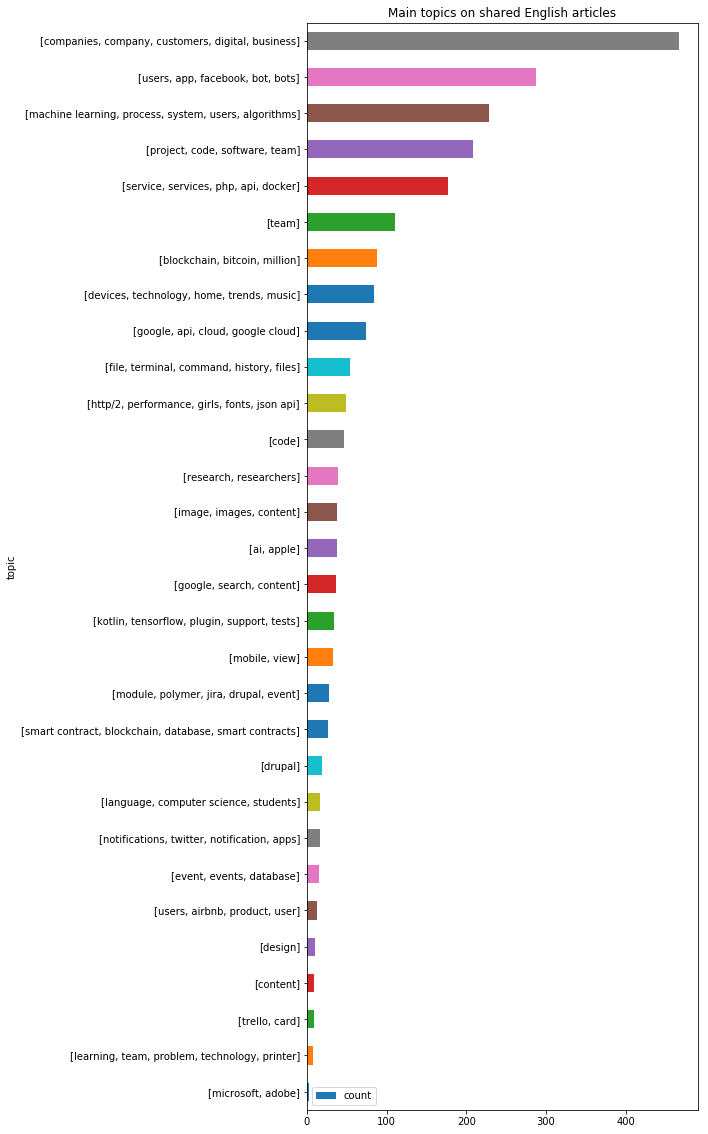

In [17]:
main_topics_df.plot(kind='barh', x='topic', y='count', figsize=(7,20), title='Main topics on shared English articles')